In [2]:

import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# image handler
from PIL import Image

# basic train and test matrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)

# py torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# optimisers and schedulers
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# torch vision transforms and such
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.models import resnet18,ResNet18_Weights
# progress bar for waiting
from tqdm.auto import tqdm

DATA SET LOADING

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  79950 non-null  int64 
 1   file_name   79950 non-null  object
 2   label       79950 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ MB
None 

Missing values per column:
Unnamed: 0    0
file_name     0
label         0
dtype: int64 

Index(['file_name', 'label'], dtype='object')


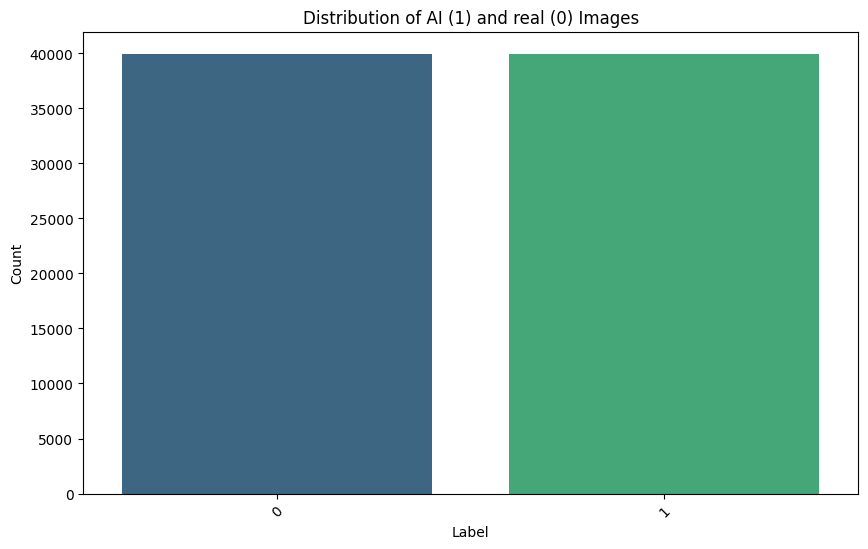

In [3]:
BASE_PATH = "/kaggle/input/shutterstock-dataset-for-ai-vs-human-gen-image"

trainData = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))
testData = pd.read_csv(os.path.join(BASE_PATH, "test.csv"))

trainData.head()

print("Dataset Info:")
print(trainData.info(), "\n")

print("Missing values per column:")
print(trainData.isnull().sum(), "\n")

if 'Unnamed: 0' in trainData.columns:
    trainData.drop(columns=['Unnamed: 0'], inplace=True)
print(trainData.columns)

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=trainData, palette='viridis')
plt.title('Distribution of AI (1) and real (0) Images')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

DATA SET SPLIT

80% train 20% validation and the kaggle provided testing set

In [4]:
train_df, val_df = train_test_split(trainData, test_size=0.2,stratify=trainData["label"],random_state=42)

#stratify makes sure that the classifiers used are in even magnitudes. 
# something like 20,000 AI 20,000 Real instead of 15,000 AI and 25,000 real 

print("Training size: ", len(train_df))
print("Validation size: ", len(val_df))
print("Testing size: ", len(testData))

Training size:  63960
Validation size:  15990
Testing size:  19986


IMAGE SIZING

In [5]:
train_tfms= T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_tfms= T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

DETECTOR CLASS

In [14]:
class AIDetectDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(BASE_PATH,row['file_name'])   # for train.csv
        # If you're using test.csv with 'id', use row['id'] instead

        img = Image.open(img_path).convert("RGB")

        if self.transforms:
            img = self.transforms(img)

        label = int(row["label"])   # 0 or 1
        return img, label

DATA LOADERS 

In [15]:
batch_size = 32

train_ds = AIDetectDataset(train_df, transforms=train_tfms)
val_ds   = AIDetectDataset(val_df,   transforms=val_tfms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)

# quick sanity check
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape, "Labels sample:", labels[:8])


Batch shape: torch.Size([32, 3, 224, 224]) Labels sample: tensor([1, 0, 1, 0, 1, 1, 0, 1])


DEFINING DEVICE (GPU)

In [18]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load a ResNet18 pre-trained on ImageNet
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Replace the final fully connected layer to output 2 classes (0 = real, 1 = AI)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using device: cpu


NameError: name 'ResNet18_Weights' is not defined

IMPLIMENTING RESNETS CNN MODEL

In [17]:

num_epochs = 5  # start small to test we will move to 15 when reaching a final product

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    # Train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)              # shape [batch, 2]
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validate
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}  Val   Acc: {val_acc:.4f}")


Epoch 1/5


  0%|          | 0/1999 [00:00<?, ?it/s]

KeyboardInterrupt: 

###